<!--HEADER-->
*Aprendizado Científico de Máquina: notas sobre aprendizado de máquina e equações diferenciais universais, em um contexto de computação científica. [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/NNDiffEqSciML/blob/main/notebooks/07.05-Identificacao_esparsa_Lorenz.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/NNDiffEqSciML/main?filepath=notebooks/07.05-Identificacao_esparsa_Lorenz.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/NNDiffEqSciML/blob/main/notebooks/slides/07.05-Identificacao_esparsa_Lorenz.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 7.4. Identificação esparsa de dinâmica não-linear](07.04-Identificacao_esparsa.ipynb) | [Redes Neurais, Equações Diferenciais e Aprendizado Científico de Máquina](00.00-Frente.ipynb) 

---


# Identificação esparsa do sistema de Lorenz

Continuamos o discutido na seção anterior considerando, agora, o sistema de Lorenz.

## Exemplo sistema de Lorenz

Vamos agora a outro exemplo.

### Sistema de equações

O sistema de Lorenz tem a forma
$$ \begin{cases}
    \dot x = \sigma x - \sigma y \\
    \dot y = \rho x - xz - y \\
    \dot z = xy - \beta z,
  \end{cases}
$$
onde $\sigma, \beta, \rho$ são parâmetros da sistema. Consideramos, aqui, os valores clássicos
$$  \sigma = 10, \quad \beta = 8/3, \quad \rho = 28.
$$

Escrevemos o sistema na forma vetorial
$$ \frac{\textrm{d} u}{\textrm{d} t} = F(u), \qquad u = \left(\begin{matrix} x \\ y \\ y \end{matrix}\right), \quad F(u) = \left( \begin{matrix} \sigma x - \sigma y \\ \rho x - xz - y\\ xy - \beta z  \end{matrix} \right).
$$

### Perturbação estocástica e dados sintéticos

Novamente, os dados sintéticos são gerados a partir de uma perturbação estocástica desse sistema:
$$ \frac{\textrm{d} u}{\textrm{d} t} = F(u) + \epsilon dW,
$$
onde $\epsilon>0$, $W=(W_1, W_2, W_3)$ e $W_i$, $i=1,2,3$, são processos de Wiener, agindo em cada coordenada.

## Modelo

O objetivo, agora, é procurarmos uma dinâmica da forma de uma equação com lei polinomial

$$ \begin{cases}
    \dot x = \beta^1_0 + \beta^1_1 x + \beta^1_2 y + \beta^1_3 z + \beta^1_4 x^2 + \beta^1_5 y^2 + \beta^1_6 z^2 + \beta^1_7 xy + \beta^1_8 xz + \beta^1_9 yz + \ldots \\
    \dot y = \beta^2_0 + \beta^2_1 x + \beta^2_2 y + \beta^2_3 z + \beta^2_4 x^2 + \beta^2_5 y^2 + \beta^2_6 z^2 + \beta^2_7 xy + \beta^2_8 xz + \beta^2_9 yz + \ldots \\
    \dot z = \beta^3_0 + \beta^3_1 x + \beta^3_2 y + \beta^3_3 z + \beta^3_4 x^2 + \beta^3_5 y^2 + \beta^3_6 z^2 + \beta^3_7 xy + \beta^3_8 xz + \beta^3_9 yz + \ldots,
  \end{cases}
$$

## Implementação numérica

### Geração dos dados

Primeiro importamos os pacotes

In [1]:
using DifferentialEquations
using LinearAlgebra: ⋅, I
using RandomNumbers
using Plots; gr(); theme(:ggplot2) # Using the GR backend with the :ggplot2 theme

Em seguida definimos as leis para a criação dos dados sintéticos.

In [2]:
α=1.5;
β=1;
ϵ=0.02;
function f(x,p,t) 
    α, β, ϵ = p
    return α*x - β*x^2
end
function g(x,p,t)
    α, β, ϵ = p
    return ϵ*x
end

g (generic function with 1 method)

Para fixar o ruído, para efeitos instrutivos, de reproducibilidade, definimos o processo de Wiener.

In [3]:
rng = Xorshifts.Xoroshiro128Plus(123);
noise = [WienerProcess(0., 0., rng = rng, reseed=false), WienerProcess(0., 0., rng = rng, reseed=false), WienerProcess(0., 0., rng = rng, reseed=false)];

Com o ruído fixado, resolvemos a equação estocástica, além do que seria a solução exata:

In [4]:
prob = ODEProblem(f, 0.04, (-1.0,6.0), [α, β, ϵ])
sol = solve(prob, dt=0.01)
prob_sde = SDEProblem(f, g, 0.04, (-1.0,6.0), [α, β, ϵ], noise=noise);
sol_sde = solve(prob_sde,EM(),dt=0.01);

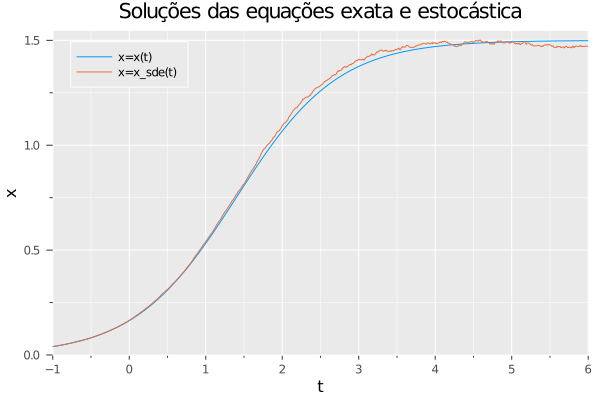

In [5]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft, title="Soluções das equações exata e estocástica")
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)", legend=:topleft)

Não usaremos todos os valores, em todo o intervalo, pois muitas vezes temos dados limitados. 

Tomamos, então, algumas amostras, em uma janela do intervalo acima:

In [6]:
data_dt = 0.1;
data_t = 0.0:data_dt:2.0;
data_x = sol_sde(data_t).u;

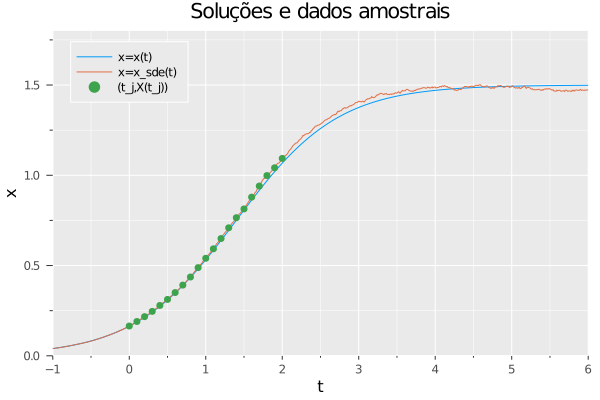

In [7]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft, title="Soluções e dados amostrais")
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)")
scatter!(data_t, data_x, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

Com esses dados, calculamos uma aproximação da derivada, usanda derivada centrada, exceto nos extremos. Há várias maneiras melhores de se fazer isso (e.g. via regularização por variação total, onde se busca os dados mais próximos com a menor variação total), mas não vamos nos preocupar com isso no momento. Até mesmo porque no caso de interesse, as derivadas serão obtidas através de uma primeira modelagem via UDE, com o SINDy entrando como um filtro a~posteriori.

In [8]:
data_dx = vcat(data_x[3:end] - data_x[1:end-2])/data_dt/2;

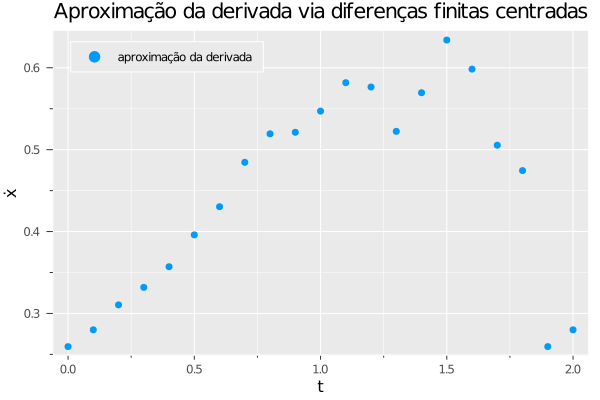

In [9]:
scatter(data_t, data_dx, xlabel="t", ylabel="ẋ", label="aproximação da derivada", legend=:topleft, title="Aproximação da derivada via diferenças finitas centradas")

### Identificação da dinâmica

Primeiramente, definimos o vetor de monômios para a busca da lei de evolução:

In [141]:
Θ(x) = [1 x x^2 x^3 x^4 x^5]

Θ (generic function with 1 method)

A lei de evolução, com a aproximação polinomial $\Theta(x)$, é dada em função de

In [142]:
# f_Θ(x,p,t) = (Θ(x)*p)[1]
# f_Θ(x,p,t) = Θ(x)[:]'*p
f_Θ(x,p,t) = Θ(x)⋅p # With dot is way faster

f_Θ (generic function with 1 method)

A partir do vetor de monômios, criamos a matriz de dados, que chamamos aqui simplesmente de $\hat \Theta =\Theta(\hat X)$.

In [143]:
Θ̂ = vcat(Θ.(data_x)...)[2:end-1,:]

19×6 Array{Float64,2}:
 1.0  0.19      0.0361002  0.00685905  0.00130322  0.000247613
 1.0  0.216811  0.0470069  0.0101916   0.00220965  0.000479077
 1.0  0.246003  0.0605175  0.0148875   0.00366237  0.000900954
 1.0  0.278898  0.0777843  0.0216939   0.0060504   0.00168745
 1.0  0.312374  0.0975775  0.0304807   0.00952138  0.00297423
 1.0  0.35031   0.122717   0.0429891   0.0150595   0.0052755
 1.0  0.391567  0.153325   0.0600371   0.0235086   0.0092052
 1.0  0.436377  0.190425   0.0830971   0.0362617   0.0158238
 1.0  0.488468  0.238601   0.116549    0.0569306   0.0278088
 1.0  0.540241  0.29186    0.157675    0.0851825   0.0460191
 1.0  0.592707  0.351301   0.208219    0.123413    0.0731475
 1.0  0.649654  0.422051   0.274187    0.178127    0.115721
 1.0  0.709058  0.502764   0.356489    0.252771    0.17923
 1.0  0.764953  0.585154   0.447615    0.342405    0.261924
 1.0  0.813531  0.661833   0.538422    0.438023    0.356345
 1.0  0.878854  0.772384   0.678813    0.596577    0.524304

Temos, também, o vetor das derivadas, que simplesmente renomeamos de $\hat Y$, para usar a mesma nomenclatura da discussão teórica acima:

In [144]:
Ŷ = data_dx

19-element Array{Float64,1}:
 0.25952744500428515
 0.280013184664722
 0.3104379159198621
 0.33185485328884573
 0.3570584316459502
 0.39596727075045773
 0.43033511716535827
 0.48450394558120446
 0.5193199414781887
 0.5211925896265509
 0.5470661519281844
 0.5817582040043084
 0.5764955356107093
 0.5223642160086278
 0.569501795769598
 0.6338063176332104
 0.5983345099317372
 0.5054488165873899
 0.47442395772192225

Com esses objetos, obtemos, a seguir, as leis aproximadas de acordo com cada método.

### Aproximação via erro quadrático médio

Nesse, temos

In [145]:
Ξ_rms = Θ̂\Ŷ

6-element Array{Float64,1}:
   0.8266623422811884
  -7.904001224191176
  38.0891563284238
 -74.91868913096445
  67.07580085940711
 -22.631824126948462

Agora, se considerarmos a equação diferencial com esses parâmetros, obtemos

In [146]:
t₀ = 0.0;
tspan = (t₀,6.0);
x₀=sol_sde(t₀);
prob_rms = ODEProblem(f_Θ, x₀, tspan, Ξ_rms);
sol_rms = solve(prob_rms);

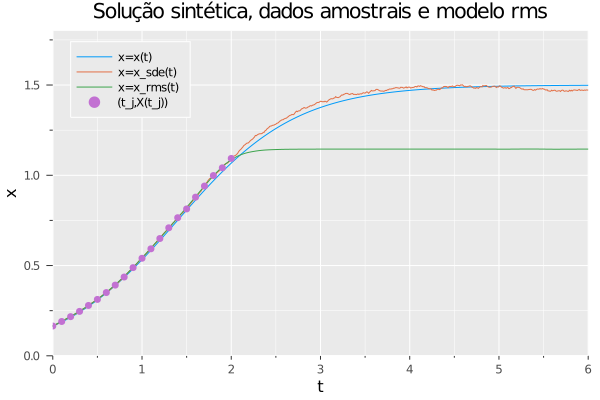

In [147]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft)
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)", legend=:topleft)
plot!(sol_rms, xlabel="t", ylabel="x", label="x=x_rms(t)", legend=:topleft, title="Solução sintética, dados amostrais e modelo rms")
scatter!(data_t, data_x, xrange=tspan, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

### Aproximação via regressão Ridge

Agora, precisamos escolher um parâmetros $\lambda$ e ser mais explícitos na resolução do problema linear. Reescrevemos
$$ (\Theta(\hat X)^t\Theta(\hat X) + m\lambda I) \Xi = \Theta(\hat X)^t\hat Y.
$$
como
$$ (\Theta(\hat X)^t\Theta(\hat X) + \mu I) \Xi = \Theta(\hat X)^t\hat Y.
$$
onde $\mu=m\lambda$.

In [148]:
μ = 0.1
Ξ_ridge = (Θ̂'*Θ̂ + μ*I)\(Θ̂'*Ŷ)

6-element Array{Float64,1}:
  0.21887393634055174
  0.4303281178997679
  0.20924865427467754
  0.011225961522698277
 -0.12262157296938095
 -0.21221256857298856

In [149]:
prob_ridge = ODEProblem(f_Θ, x₀, tspan, Ξ_ridge);
sol_ridge = solve(prob_ridge);

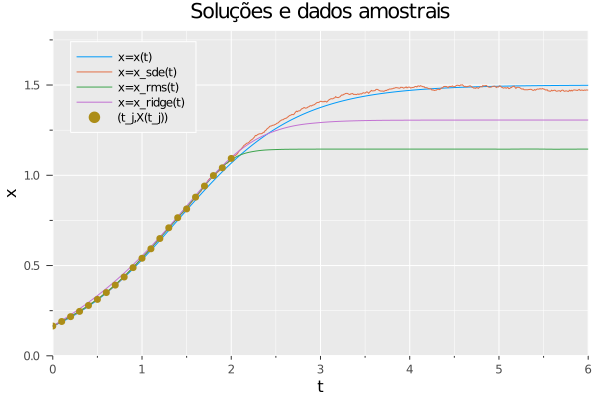

In [150]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft, title="Soluções e dados amostrais")
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)")
plot!(sol_rms, xlabel="t", ylabel="x", label="x=x_rms(t)")
plot!(sol_ridge, xlabel="t", ylabel="x", label="x=x_ridge(t)")
scatter!(data_t, data_x, xrange=tspan, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

### Diferentes fatores de penalização

In [151]:
Ξ_ridges = []
μ_range = (0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0, 20.0, 100.0)
for μ in μ_range
    append!(Ξ_ridges, [(Θ̂'*Θ̂ + μ*I)\(Θ̂'*Ŷ)])
end

In [152]:
sol_ridges = []
for j in 1:length(μ_range)
    println("Resolvendo para μ=$(μ_range[j])...")
    append!(sol_ridges, [solve(ODEProblem(f_Θ, x₀, tspan, Ξ_ridges[j]))])
end

Resolvendo para μ=0.01...
Resolvendo para μ=0.05...
Resolvendo para μ=0.1...
Resolvendo para μ=0.25...
Resolvendo para μ=0.5...
Resolvendo para μ=1.0...
Resolvendo para μ=5.0...
Resolvendo para μ=10.0...


┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/rrosa/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:349


Resolvendo para μ=20.0...
Resolvendo para μ=100.0...


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/rrosa/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/rrosa/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:349


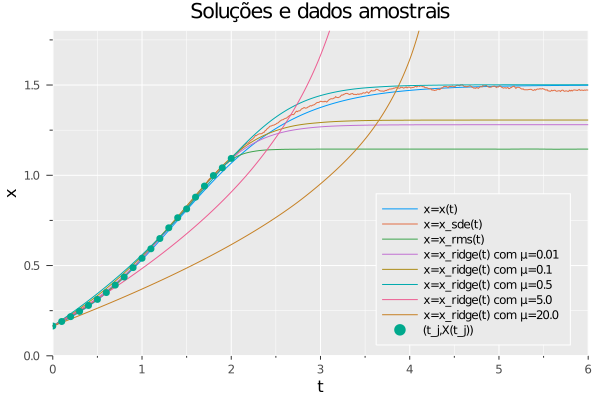

In [153]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:bottomright, title="Soluções e dados amostrais")
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)")
plot!(sol_rms, xlabel="t", ylabel="x", label="x=x_rms(t)")
for j in 1:2:length(μ_range)
    plot!(sol_ridges[j], xlabel="t", ylabel="x", label="x=x_ridge(t) com μ=$(μ_range[j])")
end
scatter!(data_t, data_x, xrange=tspan, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

### SINDy

In [182]:
Ξ_sindy = copy(Ξ_rms)
μ̄ = 0.5
for k = 1:length(Ξ_sindy)
    small_inds = abs.(Ξ_sindy) .< μ̄
    big_inds = abs.(Ξ_sindy) .>= μ̄
    Ξ_sindy[small_inds] .= 0.0
    Ξ_sindy[big_inds] = Θ̂[:,big_inds]\Ŷ
end

Ξ_sindy

6-element Array{Float64,1}:
   0.8266623422811884
  -7.904001224191176
  38.0891563284238
 -74.91868913096445
  67.07580085940711
 -22.631824126948462

In [183]:
sol_sindy = solve(ODEProblem(f_Θ, x₀, tspan, Ξ_sindy));

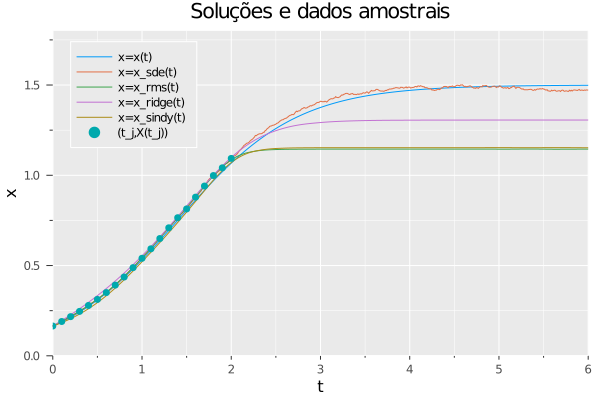

In [181]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft, title="Soluções e dados amostrais")
plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)")
plot!(sol_rms, xlabel="t", ylabel="x", label="x=x_rms(t)")
plot!(sol_ridge, xlabel="t", ylabel="x", label="x=x_ridge(t)")
plot!(sol_sindy, xlabel="t", ylabel="x", label="x=x_sindy(t)")
scatter!(data_t, data_x, xrange=tspan, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

### Ridge-SINDy

In [168]:
Ξ_ridgesindy = copy(Ξ_rms)
μ̄ = 0.1
μ = 0.25
for k = 1:length(Ξ_ridgesindy)
    small_inds = abs.(Ξ_ridgesindy) .< μ̄
    big_inds = abs.(Ξ_ridgesindy) .>= μ̄
    Ξ_ridgesindy[small_inds] .= 0.0
    Ξ_ridgesindy[big_inds] = (Θ̂[:,big_inds]'*Θ̂[:,big_inds] + μ*I)\(Θ̂[:,big_inds]'*Ŷ)
end

Ξ_ridgesindy

6-element Array{Float64,1}:
  0.25935422763646154
  0.3348209020832
  0.1560214315506471
  0.0
  0.0
 -0.19783527470782225

In [169]:
sol_ridgesindy = solve(ODEProblem(f_Θ, x₀, tspan, Ξ_ridgesindy));

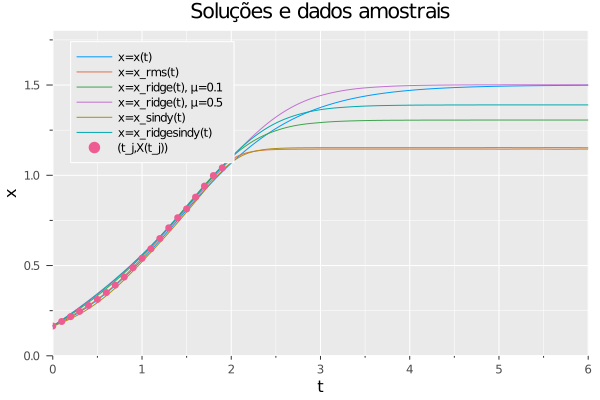

In [173]:
plot(sol, xlabel="t", ylabel="x", label="x=x(t)", legend=:topleft, title="Soluções e dados amostrais")
#plot!(sol_sde, xlabel="t", ylabel="x", label="x=x_sde(t)")
plot!(sol_rms, xlabel="t", ylabel="x", label="x=x_rms(t)")
plot!(sol_ridges[3], xlabel="t", ylabel="x", label="x=x_ridge(t), μ=$(μ_range[3])")
plot!(sol_ridges[5], xlabel="t", ylabel="x", label="x=x_ridge(t), μ=$(μ_range[5])")
plot!(sol_sindy, xlabel="t", ylabel="x", label="x=x_sindy(t)")
plot!(sol_ridgesindy, xlabel="t", ylabel="x", label="x=x_ridgesindy(t)")
scatter!(data_t, data_x, xrange=tspan, yrange=(0.0, 1.2*α/β), xlabel="t", ylabel="x", label="(t_j,X(t_j))")

## Exemplo sistema de Lorenz

Vamos agora a outro exemplo.

### Sistema de equações

O sistema de Lorenz tem a forma
$$ \begin{cases}
    \dot x = \sigma x - \sigma y \\
    \dot y = \rho x - xz - y \\
    \dot z = xy - \beta z,
  \end{cases}
$$
onde $\sigma, \beta, \rho$ são parâmetros da sistema. Consideramos, aqui, os valores clássicos
$$  \sigma = 10, \quad \beta = 8/3, \quad \rho = 28.
$$

Escrevemos o sistema na forma vetorial
$$ \frac{\textrm{d} u}{\textrm{d} t} = F(u), \qquad u = \left(\begin{matrix} x \\ y \\ y \end{matrix}\right), \quad F(u) = \left( \begin{matrix} \sigma x - \sigma y \\ \rho x - xz - y\\ xy - \beta z  \end{matrix} \right).
$$

### Perturbação estocástica e dados sintéticos

Novamente, os dados sintéticos são gerados a partir de uma perturbação estocástica desse sistema:
$$ \frac{\textrm{d} u}{\textrm{d} t} = F(u) + \epsilon dW,
$$
onde $\epsilon>0$, e $W=(W_1, W_2, W_3)$ são processos de Wiener, agindo em cada coordenada.

O objetivo, agora, é procurarmos uma dinâmica da forma de uma equação com lei polinomial

$$ \frac{\textrm{d} u}{\textrm{d} t} = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + a_4x^4.
$$

## References

* S. L. Brunton, J. L. Proctor, and J. N. Kutz (2016), Discovering governing equations from data by sparse identification of nonlinear dynamical systems, PNAS April 12 (2016), 113 (15) 3932-3937 [doi: 10.1073/pnas.1517384113](https://doi.org/10.1073/pnas.1517384113

* S. L. Brunton, J. L. Proctor, and J. N. Kutz (2016), Supporting Information to Discovering governing equations [Supplemental Material](https://www.pnas.org/content/pnas/suppl/2016/03/23/1517384113.DCSupplemental/pnas.1517384113.sapp.pdf)

* E. Kaiser, J. N. Kutz, and S. L. Brunton (2018), Sparse identification of nonlinear dynamics for model predictive control in the low-data limit, Proc. R. Soc. A. 474, issue 2219 [doi: 10.1098/rspa.2018.0335](https://doi.org/10.1098/rspa.2018.0335)

* P. Zheng, T. Askham, S. L. Brunton, J. N. Kutz and A. Y. Aravkin, "A Unified Framework for Sparse Relaxed Regularized Regression: SR3," in IEEE Access, vol. 7, pp. 1404-1423, 2019, [doi: 10.1109/ACCESS.2018.2886528](https://ieeexplore.ieee.org/document/8573778).

* [SciML/DataDrivenDiffEq.jl/Sparse Identification of Nonlinear Dynamics](https://datadriven.sciml.ai/dev/sparse_identification/sindy/#Sparse-Identification-of-Nonlinear-Dynamics-1)

<!--NAVIGATOR-->

---
[<- 7.4. Identificação esparsa de dinâmica não-linear](07.04-Identificacao_esparsa.ipynb) | [Redes Neurais, Equações Diferenciais e Aprendizado Científico de Máquina](00.00-Frente.ipynb) 